# Code for Strata (May-2018) talk: 

## Operationalize deep learning models for fraud detection with Azure Machine Learning Workbench

https://conferences.oreilly.com/strata/strata-eu/public/schedule/detail/64891

## References: 

- Preconfigured Virtual Machines: https://azure.microsoft.com/en-us/services/virtual-machines/data-science-virtual-machines/ 

- Data Source: https://www.kaggle.com/mlg-ulb/creditcardfraud

- Blog Post by Venelin Valkov: https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd

- Deep Learning Book by Ian Goodfellow, Yoshua Bengio, Aaron Courville: http://www.deeplearningbook.org/ 

## Environment setup

In [1]:
# Import necessary components
import os
import keras
import shutil
import json

In [2]:
import re
import pandas as pd
import numpy as np
import datetime

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from math import ceil

In [3]:
import pickle
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [4]:
# For creating the deployment schema file
from azureml.api.schema.dataTypes import DataTypes
from azureml.api.schema.sampleDefinition import SampleDefinition
from azureml.api.realtime.services import generate_schema

In [5]:
import matplotlib as plt 

In [6]:
%matplotlib inline

In [7]:
import glob
import os

from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

Enter the credentials to access the data from the cloud and then download the file for analysis.

In [8]:
# Azure blob credentials to read data
storage_account = 'jayastratalondon'
storage_key = 'OZr4vx9xLlNTOWlC+u/Yw/hb4N1v4BSB0ITFUz7zyvKsA0lEV+ohxQ5x3RIaUK3f+TMnRxvn/lpDzWSr7YJyww=='

input_container = 'stratalondon'
output_container = 'modeldeploy'

az_blob_service = BlockBlobService(account_name=storage_account, account_key=storage_key)

In [9]:
blob_service = BlockBlobService(account_name=storage_account, account_key=storage_key)
input_container_folder = 'stratalondon/'
generator = blob_service.list_blobs(input_container_folder)
for blob in generator:
    if ("creditcard" in blob.name):
        print(blob.name)
        fname=blob.name

creditcard.csv


In [10]:
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
my_service = BlockBlobService(account_name=storage_account, account_key=storage_key)
my_service.get_blob_to_path('stratalondon', fname, '/azureml-share/creditcard.csv')

## Import the Credit card data set

In [11]:
# Check the path
aml_dir

'/azureml-share/'

In [12]:
# Ingest the dataset
cc = pd.read_csv(aml_dir+'creditcard.csv')

After data ingestion from Blob, check to see the various columns and number of rows/columns of the dataset.

In [13]:
# Check sample data
cc.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


In [14]:
# Check the number of rows/columns
cc.shape

(284807, 31)

Now that the data is properly imported, check the descriptive statistics of the columns in the dataset.

In [15]:
# Check data statistics
print(cc.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.165980e-15  3.416908e-16 -1.373150e-15  2.086869e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.490107e-15 -5.556467e-16  1.177556e-16 -2.406455e-15   
std    1.380247e+00  1.332271e+00  1.23709

Here we visualize and access the distribution of the variable 'Class'. This is the variable which indicates whether a transaction was fraud/normal. 

In [16]:
from matplotlib import pyplot as plt 

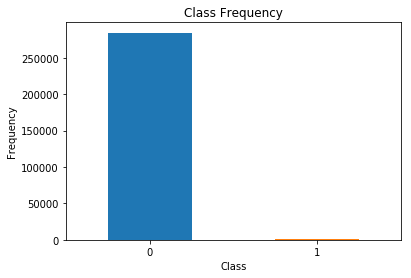

In [17]:
# Variable class is used for the classification of entries as fraud/non-fraud, check the distribution of the variable
class_freq = pd.value_counts(cc['Class'], sort = True)
class_freq.plot(kind = 'bar', rot=0)
plt.title("Class Frequency")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [18]:
# Count of Fraud/normal transactions
fraud = cc[cc.Class == 1]
normal = cc[cc.Class == 0]
print("Number of Fraud transactions:")
print(fraud.shape)
print("Number of Non-Fraud transactions:")
print(normal.shape)
print("% of Fraud transactions:")
prop = (len(fraud)/(len(fraud)+len(normal)))*100
print(prop)

Number of Fraud transactions:
(492, 31)
Number of Non-Fraud transactions:
(284315, 31)
% of Fraud transactions:
0.1727485630620034


Check to see how the fraud/normal transactions vary in terms of variable 'Amount'.

In [19]:
# Check Fraud data statistics for variable = 'Amount'
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [20]:
# Compare Fraud data statistics with normal data for variable = 'Amount'
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Modeling 

First exclude the variable 'Time'. Since the spread of the variable 'Amount' is large, this variable is standardized. 

In [21]:
# Remove the column 'Time' and standardize the variable 'Amount'
from sklearn.preprocessing import StandardScaler
data = cc.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

Next step is to split the data into train/test.

In [22]:
# Split the data into train/test and remove variable 'Class' and prepare for autoencoder
X_train, X_test = train_test_split(data, test_size=0.3, random_state=123)
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values

print("X_train:")
print(X_train.shape)
print("X_test:")
print(X_test.shape)

X_train:
(199364, 29)
X_test:
(85443, 29)


In [23]:
X_test[1]

array([ 2.15574786, -0.99822258, -1.15897829, -0.99229813, -0.48459951,
       -0.30885748, -0.67707687, -0.19351731, -0.08302644,  0.70535673,
       -1.55210692, -0.41524791,  1.04034025, -0.53313654,  0.07619587,
        1.2201284 , -0.14748371, -1.22145703,  0.87802608,  0.12463626,
        0.17477517,  0.51900531,  0.00346   , -1.01796213, -0.00946463,
       -0.11843454, -0.00634987, -0.05337546, -0.12134039])

Define the framework for the autoencoder and then compile and fit using the training data.

In [24]:
# Define the encoded/decoder framework
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [25]:
# Compile and fit the autoencoder
nb_epoch = 5
batch_size = 32
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True, validation_data=(X_test, X_test), verbose=1).history

Train on 199364 samples, validate on 85443 samples
Epoch 1/5
199364/199364 [==============================] - 15s 74us/step - loss: 0.8534 - acc: 0.5970 - val_loss: 0.7937 - val_acc: 0.6356
Epoch 2/5
199364/199364 [==============================] - 15s 76us/step - loss: 0.7979 - acc: 0.6400 - val_loss: 0.7790 - val_acc: 0.6412
Epoch 3/5
199364/199364 [==============================] - 15s 73us/step - loss: 0.7886 - acc: 0.6447 - val_loss: 0.7738 - val_acc: 0.6429
Epoch 4/5
199364/199364 [==============================] - 15s 73us/step - loss: 0.7843 - acc: 0.6457 - val_loss: 0.7694 - val_acc: 0.6444
Epoch 5/5
199364/199364 [==============================] - 15s 74us/step - loss: 0.7810 - acc: 0.6488 - val_loss: 0.7669 - val_acc: 0.6412


In [26]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

In [27]:
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,85443.000000,85443.000000
mean,0.759570,0.001873
std,3.740318,0.043233
min,0.050708,0.000000
25%,0.251755,0.000000
50%,0.408373,0.000000
75%,0.648617,0.000000
max,438.508700,1.000000


The model can be accessed based on various metrics: ROC curve, precision, recall based on the business requirement. 

In [28]:
# Metrics
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

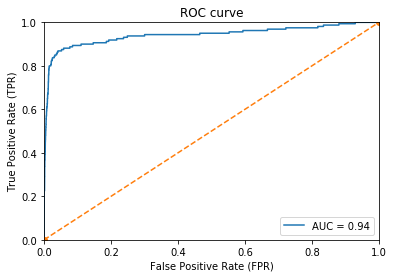

In [29]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'o--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')
plt.show();

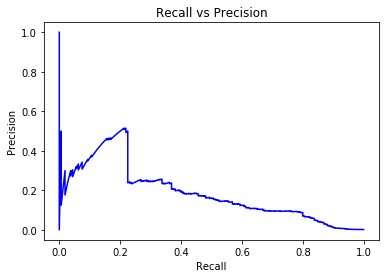

In [30]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## Saving the model

In [31]:
autoencoder

In [32]:
# Save the model for operationalization: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
from keras.models import model_from_json
import os
import h5py
from sklearn import datasets 
 
# save model
# serialize model to JSON
model_json = autoencoder.to_json()
with open(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'] +"autoencoder.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'], "autoencoder.h5"))
print("Model saved")

Model saved


In [33]:
# load json and create model
json_file = open(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'] +'autoencoder.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'],"autoencoder.h5"))
print("Model loaded")

Model loaded


In [34]:
score = loaded_model.predict(X_test)
print(score.shape)

(85443, 29)


In [35]:
score[1]

array([2.1914716 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00409213, 1.0543662 ,
       0.        , 0.        , 0.        , 0.        , 0.2314117 ,
       0.8779192 , 0.        , 0.        , 0.43132922, 0.        ,
       0.        , 0.03038263, 0.04093704, 0.        , 0.02934054,
       0.        , 0.        , 0.        , 0.        ], dtype=float32)

In [36]:
X_test[1]

array([ 2.15574786, -0.99822258, -1.15897829, -0.99229813, -0.48459951,
       -0.30885748, -0.67707687, -0.19351731, -0.08302644,  0.70535673,
       -1.55210692, -0.41524791,  1.04034025, -0.53313654,  0.07619587,
        1.2201284 , -0.14748371, -1.22145703,  0.87802608,  0.12463626,
        0.17477517,  0.51900531,  0.00346   , -1.01796213, -0.00946463,
       -0.11843454, -0.00634987, -0.05337546, -0.12134039])

## Operationalization

## Test init() and run() functions
The web service requires two functions, an init() function that will initialize the web service by loading the model into the service, and a run() function that will engineer the features to match the model call structure, and score that data set. We create the functions in here for testing and debugging.

In [37]:
def init():
    # read in the model file
    from keras.models import model_from_json
    global loaded_model
    
    # load json and create model
    with open(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'] +'autoencoder.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

In [38]:
# sample data to test init() and run() functions
test_run = cc.head(5)
test_run

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [39]:
# test with original input columns
def run(test_run): 
    
    # data prep
    # pick the feature columns   
    input_data = test_run.drop(['Time', 'Class'], axis=1)
#    print(input_data.head(1))
    
    try:
        prediction = loaded_model.predict(input_data)
        #print(prediction)
        pred = prediction.tolist()
        return(pred)
    except Exception as e:
        return(str(e))

In [40]:
init()

In [41]:
prob=run(test_run)

In [42]:
prob[1]

[0.0,
 0.0,
 0.0,
 0.0,
 0.45636293292045593,
 0.0951371118426323,
 0.46782439947128296,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.48221734166145325,
 1.0084260702133179,
 0.6066235899925232,
 0.0,
 0.7527502179145813,
 0.0,
 0.5569592118263245,
 0.0,
 0.0,
 0.0,
 0.5078699588775635,
 0.0,
 0.0,
 0.18658503890037537,
 0.0,
 0.0]

## Persist model assets

Next we persist the assets we have created earlier. First we need to define the schema.

In [43]:
# define the input data frame
inputs = {"test_run": SampleDefinition(DataTypes.PANDAS, test_run)}

json_schema = generate_schema(run_func=run, inputs=inputs, filepath='service_schema.json')

# save the schema file for deployment
out = json.dumps(json_schema)
with open(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'] + 'service_schema.json', 'w') as f:
    f.write(out)

In [44]:
out

'{"input": {"test_run": {"internal": "gANjYXp1cmVtbC5hcGkuc2NoZW1hLnBhbmRhc1V0aWwKUGFuZGFzU2NoZW1hCnEAKYFxAX1xAihYCgAAAHNjaGVtYV9tYXBxA31xBChYAwAAAFYxNHEFY251bXB5CmR0eXBlCnEGWAIAAABmOHEHSwBLAYdxCFJxCShLA1gBAAAAPHEKTk5OSv////9K/////0sAdHELYlgDAAAAVjEwcQxoCVgCAAAAVjFxDWgJWAMAAABWMTFxDmgJWAMAAABWMjRxD2gJWAIAAABWOHEQaAlYAwAAAFYxOHERaAlYAwAAAFYxNXESaAlYAgAAAFYzcRNoCVgDAAAAVjEycRRoCVgDAAAAVjE3cRVoCVgDAAAAVjE2cRZoCVgDAAAAVjIwcRdoCVgDAAAAVjEzcRhoCVgDAAAAVjIzcRloCVgDAAAAVjI1cRpoCVgCAAAAVjlxG2gJWAMAAABWMjZxHGgJWAIAAABWNHEdaAlYAgAAAFY1cR5oCVgCAAAAVjJxH2gJWAIAAABWN3EgaAlYAwAAAFYyMXEhaAlYAwAAAFYyMnEiaAlYAwAAAFYxOXEjaAlYBQAAAENsYXNzcSRoBlgCAAAAaThxJUsASwGHcSZScScoSwNoCk5OTkr/////Sv////9LAHRxKGJYAgAAAFY2cSloCVgDAAAAVjI3cSpoCVgGAAAAQW1vdW50cStoCVgDAAAAVjI4cSxoCVgEAAAAVGltZXEtaAl1WAwAAABjb2x1bW5fdHlwZXNxLl1xLyhoCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloCWgJaAloJ2VYBQAAAHNoYXBlcTBLBUsfhnExWAwAAABjb2x1bW5fbmFtZXNxMl1xMyhoLWgNaB9oE2gdaB5oKWggaBBoG2gMaA5oFGgYaAVoEmgWaBVoEWgjaB

The conda dependencies are defined in this `webservices_conda.yaml` file. This will be used to tell the webservice server which python packages are required to run this web service.

In [45]:
%%writefile {os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']}/webservices_conda.yaml

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for managed runs. These include runs against
# the localdocker, remotedocker, and cluster compute targets.

# Note that this file is NOT used to automatically manage dependencies for the
# local compute target. To provision these dependencies locally, run:
# conda env update --file conda_dependencies.yml

# Details about the Conda environment file format:
# https://conda.io/docs/using/envs.html#create-environment-file-by-hand

# For managing Spark packages and configuration, see spark_dependencies.yml.

name: project_environment
channels:
- conda-forge
- defaults
dependencies:
  - python=3.5.2
  - pip:
    - azure-common==1.1.8
    - azure-storage==0.36.0
    - numpy==1.14.0 
    - sklearn
    - keras
    - tensorflow
    - h5py

Overwriting /azureml-share//webservices_conda.yaml


The `Autoscore.py` file is python code defining the web service operation. It includes both the `init()` and `run()` functions defined earlier imports the required libraries. 

In [46]:
%%writefile {os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']}/Autoscore.py

# import the libraries
import keras
import tensorflow
import json
import shutil
import numpy as np


def init():
    # read in the model file
    from keras.models import model_from_json
    global loaded_model
    
    # load json and create model
    with open(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY'] +'autoencoder.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        
        
# test with original input columns
def run(test_run): 
    
    # data prep
    # pick the feature columns   
    input_data = test_run.drop(['Time', 'Class'], axis=1)
#    print(input_data.head(1))
    
    try:
        prediction = loaded_model.predict(input_data)
        #print(prediction)
        pred = prediction.tolist()
        return(pred)
    except Exception as e:
        return(str(e))

Overwriting /azureml-share//Autoscore.py


Retrieving the saved files: https://docs.microsoft.com/en-us/azure/machine-learning/desktop-workbench/how-to-read-write-files

In [47]:
!ls {aml_dir}

Autoscore.py	autoencoder.json  service_schema.json
autoencoder.h5	creditcard.csv	  webservices_conda.yaml


## Packaging

To move the model artifacts around, we'll zip them into one file. We can then retrieve this file from the persistence shared folder on your DSVM.

https://docs.microsoft.com/en-us/azure/machine-learning/preview/how-to-read-write-files

In [48]:
# Compress the operationalization assets for easy blob storage transfer
# We can remove the persisted data files.
# !rm {SHARE_ROOT}/PM*.pkl
!rm {aml_dir}/creditcard.csv
!ls {aml_dir}

MODEL_O16N = shutil.make_archive('Auto_o16n', 'zip', aml_dir)

# Create a new container if necessary, otherwise you can use an existing container.
# This command creates the container if it does not already exist. Else it does nothing.
az_blob_service.create_container(output_container,
                                 fail_on_exist=False, 
                                 public_access=PublicAccess.Container)

# Transfer the compressed operationalization assets into the blob container.
az_blob_service.create_blob_from_path(output_container, "Auto_o16n.zip", str(MODEL_O16N)) 

Autoscore.py	autoencoder.json     webservices_conda.yaml
autoencoder.h5	service_schema.json


## Deployment 

Once the assets are stored, we can download them into a deployment compute context for operationalization on an Azure web service. For this scenario, we will deploy this on our local context.

We demonstrate how to setup this web service this through a CLI window opened in the AML Workbench application.


### Download the model 

To download the model we've saved, follow these instructions on a local computer.

- Open the Azure Portal 

- In the left hand pane, click on All resources 

- Search for the storage account using the name you provided earlier in this notebook. 

- Choose the storage account from search result list, this will open the storage account panel.

- On the storage account panel, choose Blobs 

- On the Blobs panel choose the container modeldeploy 

- Select the file o16n.zip and on the properties pane for that blob choose download.

Once downloaded, unzip the file into the directory of your choice. 


### Create a model management endpoint 

Create a modelmanagement under your account. We will call this automodelmanagement. The remaining defaults are acceptable.

`az ml account modelmanagement create --location <ACCOUNT_REGION> --resource-group <RESOURCE_GROUP> --name automodelmanagement`

You can find the subscription name or subscription id through the (https://portal.azure.com) under the resource group you'd like to use.


### Check environment settings 

Show what environment is currently active:

`az ml env show`

If nothing is set, we setup the environment with the existing model management context first:

`az ml env setup --location <ACCOUNT_REGION> --resource-group <RESOURCE_GROUP> --name automodelmanagement`

using the same <ACCOUNT_REGION> and <RESOURCE_GROUP> in the previous section. Then set the current environment:

`az ml env set --resource-group <RESOURCE_GROUP> --cluster-name automodelmanagement`

Check that the environment is now set:

`az ml env show`


### Install docker to compute target 

Once the model management environment is setup, we'll deploy the web service from the CLI to a local docker container for this demonstration. This assumes you have docker installed localy (https://www.docker.com/get-docker).

Once docker is installed and running, you will need to prepare the local docker container, just as we didi the remote container.

`az ml experiment prepare -c docker`

Now deploy the solution to this container.


### Deploy a web service 

These commands assume the current directory contains the webservice assets we created in throughout the notebooks in this scenario. Change to the directory where the zip file was unpacked.

The command to create a web service (<SERVICE_ID>) with these operationalization assets in the current directory is:

`az ml service create realtime -f <filename> -r <TARGET_RUNTIME> -m <MODEL_FILE> -s <SCHEMA_FILE> -n <SERVICE_ID> --cpu 0.1`

The default cluster has only 2 nodes with 2 cores each. Some cores are taken for system components. AMLWorkbench asks for 1 core per service. To deploy multiple services into this cluster, we specify the cpu requirement in the service create command as (--cpu 0.1) to request 10% of a core.

For this example, we will call our webservice amlworkbenchautowebservice. This SERVICE_ID must be all lowercase, with no spaces:

`az ml service create realtime -f autoscore.py -r py -m-model-file autoencoder.json -m autoencoder.h5 -s service_schema.json --cpu 0.1 -n amlworkbenchautowebservice`

This command will take some time to execute.


### Test your deployment. 

Once complete, the az ml service create command returns sample usage commands to test the service for both PowerShell and the cmd prompt. We can view additional service usage information with the following command.

`az ml service usage realtime -i amlworkbenchautowebservice`